In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soidme/Dataset/train.csv
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_06.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_08.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_03.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_02.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_10.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_07.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_09.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_01.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_04.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/Subject_05.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_06.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_08.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_03.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_02.mat
/kaggle/input/soidme/Dataset/2015_BOE_Chiu/2015_BOE_Chiu/Subject_10.mat
/kaggle/input/soidme/

In [24]:
import numpy as np 
import pandas as pd 
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
gc.collect()

955

In [25]:
input_path = os.path.join('/kaggle/input/soidme/Dataset/2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [27]:
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

In [28]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

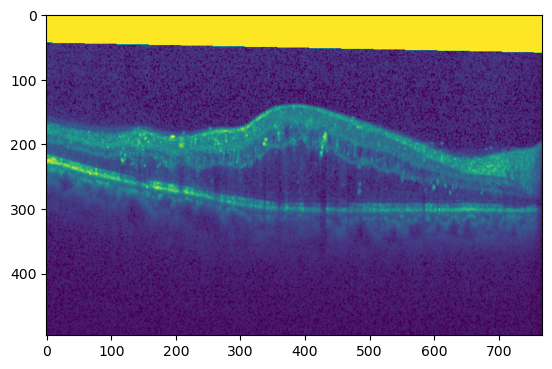

In [29]:
plt.imshow(img_array[25])

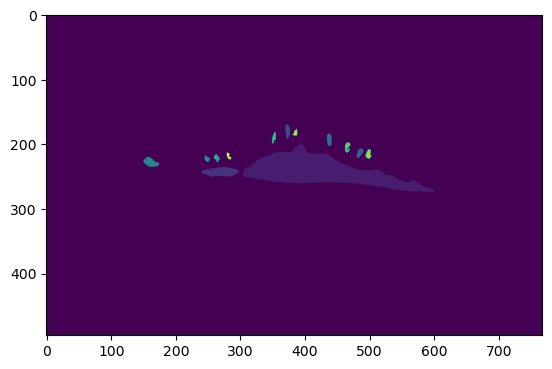

In [30]:
plt.imshow(manual_fluid_array[25])

In [31]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

/tmp/ipykernel_28/2162917096.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  thresh = np.vectorize(thresh, otypes=[np.float])
100%|██████████| 1/1 [00:12<00:00, 12.55s/it]


In [32]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

In [33]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [35]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [36]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        bottleneck1 = self.bottleneck(encode_pool3)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [37]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    outputs = unet(inputs)
    outputs = outputs.permute(0, 2, 3, 1) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [45]:
def get_val_metrics(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    outputs = outputs.permute(0, 2, 3, 1)
    outputs = outputs.resize(m * width_out * height_out, 2)
    labels = y_val.resize(m * width_out * height_out)

    # Convert outputs to predictions (argmax)
    predictions = outputs.argmax(dim=1)

    # Calculate loss
    loss = F.cross_entropy(outputs, labels)

    # Calculate accuracy
    accuracy = accuracy_score(labels.cpu(), predictions.cpu())

    # Calculate Jaccard Score (IoU)
    jaccard = jaccard_score(labels.cpu(), predictions.cpu(), average='weighted')

    # Calculate F1 Score
    f1 = f1_score(labels.cpu(), predictions.cpu(), average='weighted')

    return loss.item(), accuracy, jaccard, f1

In [39]:
learning_rate = 0.01
unet = UNet(in_channel=1,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [40]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    outputs = outputs.permute(0, 2, 3, 1)
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [46]:
epoch_iter = len(x_train) // batch_size
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss

    if (_+1) % epoch_lapse == 0:
        val_loss, val_accuracy, val_jaccard, val_f1 = get_val_metrics(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter}")
        print(f"Validation loss: {val_loss}")
        print(f"Validation accuracy: {val_accuracy}")
        print(f"Validation Jaccard Score (IoU): {val_jaccard}")
        print(f"Validation F1 Score: {val_f1}")

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
  5%|▌         | 50/1000 [04:05<1:19:59,  5.05s/it]

Total loss in epoch 50 : 0.4316119849681854
Validation loss: 0.5091419816017151
Validation accuracy: 0.8344723789330203
Validation Jaccard Score (IoU): 0.8310570214747937
Validation F1 Score: 0.9062641905763711


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 10%|█         | 100/1000 [08:12<1:15:47,  5.05s/it]

Total loss in epoch 100 : 0.2708985209465027
Validation loss: 0.296173632144928
Validation accuracy: 0.962110957555564
Validation Jaccard Score (IoU): 0.9585614744395969
Validation F1 Score: 0.9771316207775006


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 15%|█▌        | 150/1000 [12:18<1:11:34,  5.05s/it]

Total loss in epoch 150 : 0.2697087824344635
Validation loss: 0.48143455386161804
Validation accuracy: 0.9124654500018932
Validation Jaccard Score (IoU): 0.9090087823069509
Validation F1 Score: 0.9507234797731329


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 20%|██        | 200/1000 [16:24<1:07:24,  5.06s/it]

Total loss in epoch 200 : 0.25555363297462463
Validation loss: 0.3684026896953583
Validation accuracy: 0.90026882738253
Validation Jaccard Score (IoU): 0.8968867149049845
Validation F1 Score: 0.9439996578619394


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 25%|██▌       | 250/1000 [20:30<1:03:05,  5.05s/it]

Total loss in epoch 250 : 0.2542216181755066
Validation loss: 0.2809786796569824
Validation accuracy: 0.9949618530157889
Validation Jaccard Score (IoU): 0.9912685895491467
Validation F1 Score: 0.9937823858671395


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 30%|███       | 300/1000 [24:36<58:55,  5.05s/it]  

Total loss in epoch 300 : 0.25220760703086853
Validation loss: 0.30926650762557983
Validation accuracy: 0.9935112263829465
Validation Jaccard Score (IoU): 0.9898276780311968
Validation F1 Score: 0.9930643055252252


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 35%|███▌      | 350/1000 [28:42<54:39,  5.05s/it]

Total loss in epoch 350 : 0.24668113887310028
Validation loss: 0.26964133977890015
Validation accuracy: 0.9955700276399985
Validation Jaccard Score (IoU): 0.9919090498549064
Validation F1 Score: 0.9941551078408084


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 40%|████      | 400/1000 [32:48<50:31,  5.05s/it]

Total loss in epoch 400 : 0.24016073346138
Validation loss: 0.3634181022644043
Validation accuracy: 0.9843554768846314
Validation Jaccard Score (IoU): 0.9807328600036278
Validation F1 Score: 0.9885094703241118


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 45%|████▌     | 450/1000 [36:54<46:18,  5.05s/it]

Total loss in epoch 450 : 0.659372866153717
Validation loss: 0.5895718336105347
Validation accuracy: 0.8610971754193328
Validation Jaccard Score (IoU): 0.8578857465271422
Validation F1 Score: 0.9219190673437402


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 50%|█████     | 500/1000 [41:00<41:56,  5.03s/it]

Total loss in epoch 500 : 0.7198998332023621
Validation loss: 0.404125452041626
Validation accuracy: 0.9915754799136723
Validation Jaccard Score (IoU): 0.9878854575431792
Validation F1 Score: 0.992065340561971


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 55%|█████▌    | 550/1000 [45:05<37:45,  5.03s/it]

Total loss in epoch 550 : 0.5616353154182434
Validation loss: 0.4472781717777252
Validation accuracy: 0.9469965166029306
Validation Jaccard Score (IoU): 0.9434717391834826
Validation F1 Score: 0.9691578542598461


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 60%|██████    | 600/1000 [49:10<33:34,  5.04s/it]

Total loss in epoch 600 : 0.41218096017837524
Validation loss: 0.324916809797287
Validation accuracy: 0.9557949339290447
Validation Jaccard Score (IoU): 0.9522532876496828
Validation F1 Score: 0.9738182231972955


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 65%|██████▌   | 650/1000 [53:16<29:25,  5.04s/it]

Total loss in epoch 650 : 0.2704993784427643
Validation loss: 0.2658138573169708
Validation accuracy: 0.9705804399681951
Validation Jaccard Score (IoU): 0.966967544223832
Validation F1 Score: 0.981403777903569


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 70%|███████   | 700/1000 [57:22<25:15,  5.05s/it]

Total loss in epoch 700 : 0.258042573928833
Validation loss: 0.2937990128993988
Validation accuracy: 0.9367261746999357
Validation Jaccard Score (IoU): 0.9332392983207684
Validation F1 Score: 0.9637286989890129


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 75%|███████▌  | 750/1000 [1:01:28<21:01,  5.05s/it]

Total loss in epoch 750 : 0.2553679943084717
Validation loss: 0.3392195999622345
Validation accuracy: 0.9121483472795426
Validation Jaccard Score (IoU): 0.9087500722544825
Validation F1 Score: 0.9505070098493649


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 80%|████████  | 800/1000 [1:05:33<16:47,  5.04s/it]

Total loss in epoch 800 : 0.2540639042854309
Validation loss: 0.38100409507751465
Validation accuracy: 0.9025429745181932
Validation Jaccard Score (IoU): 0.8991783206871857
Validation F1 Score: 0.9452455853631079


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 85%|████████▌ | 850/1000 [1:09:39<12:35,  5.04s/it]

Total loss in epoch 850 : 0.2528234124183655
Validation loss: 0.46676579117774963
Validation accuracy: 0.884903543977888
Validation Jaccard Score (IoU): 0.8815988507246993
Validation F1 Score: 0.9354426360384228


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 90%|█████████ | 900/1000 [1:13:44<08:24,  5.04s/it]

Total loss in epoch 900 : 0.251950740814209
Validation loss: 0.5740333795547485
Validation accuracy: 0.8801635682102155
Validation Jaccard Score (IoU): 0.8768799225036863
Validation F1 Score: 0.9327771544651459


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 95%|█████████▌| 950/1000 [1:17:50<04:12,  5.06s/it]

Total loss in epoch 950 : 0.24753640592098236
Validation loss: 0.4973811209201813
Validation accuracy: 0.9165830525159971
Validation Jaccard Score (IoU): 0.9131685132186124
Validation F1 Score: 0.9529188308004335


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
100%|██████████| 1000/1000 [1:21:55<00:00,  4.92s/it]

Total loss in epoch 1000 : 0.24550466239452362
Validation loss: 0.5804774165153503
Validation accuracy: 0.8989317897845595
Validation Jaccard Score (IoU): 0.8955828784263666
Validation F1 Score: 0.9432527509884475


In [47]:
gc.collect()

1763

In [48]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

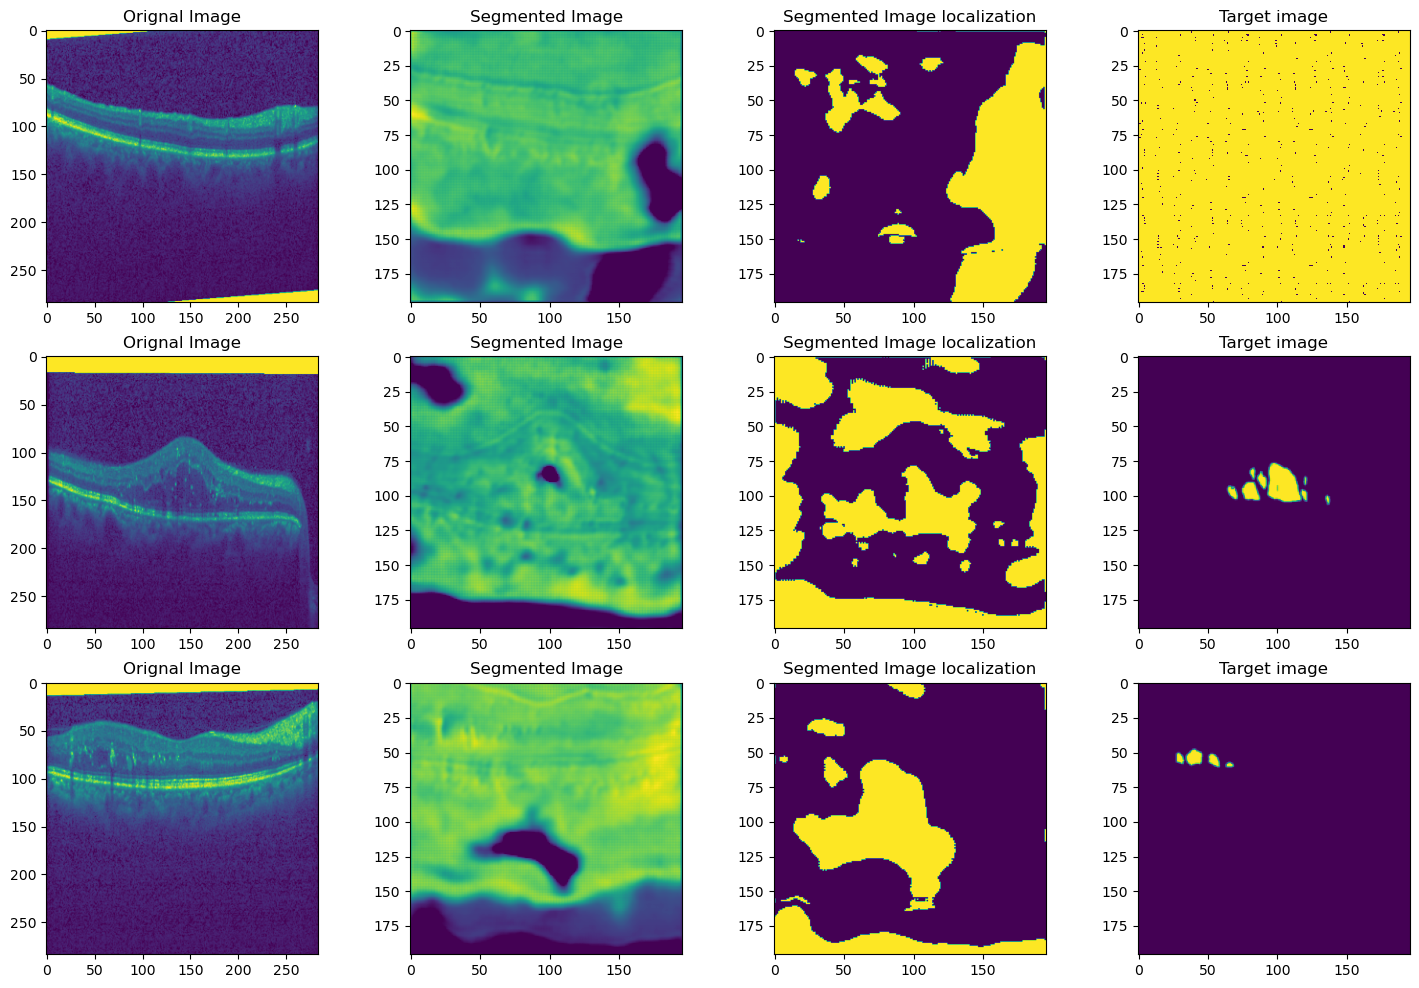

In [49]:
plot_examples(x_train, y_train)

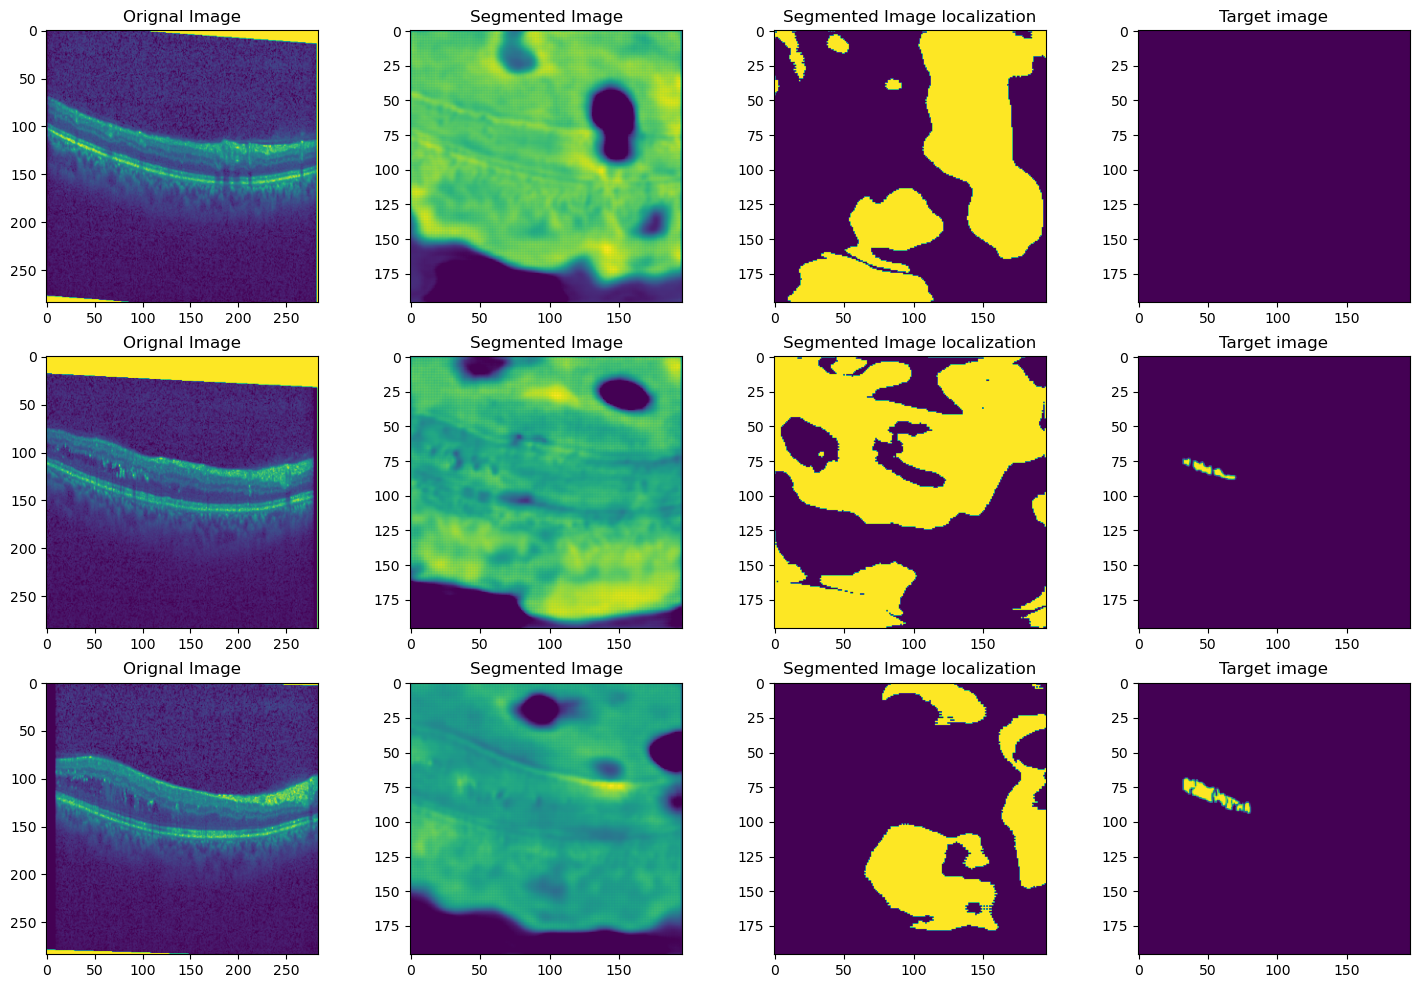

In [50]:
plot_examples(x_val, y_val)